In [17]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,Literal,Annotated
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage,HumanMessage
import os
import operator
from dotenv import load_dotenv
load_dotenv()
groq_api=os.getenv("test_groq")

In [27]:
generator_llm = ChatGroq(
    api_key=groq_api,
    model_name="openai/gpt-oss-20b"
)

evaluator_llm = ChatGroq(
    api_key=groq_api,
    model_name="deepseek-r1-distill-llama-70b"
)

optimizer_llm = ChatGroq(
    api_key=groq_api,
    model_name="llama-3-70b-instruct"
)


In [28]:
from pydantic import BaseModel, Field

class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

In [29]:
structured_evaluator_llm = evaluator_llm.with_structured_output(TweetEvaluation)

In [30]:
# state
class TweetState(TypedDict):

    topic: str
    tweet: str
    evaluation: Literal["approved", "needs_improvement"]
    feedback: str
    iteration: int
    max_iteration: int

    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]

In [31]:
def generate_tweet(state: TweetState):

    # prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]

    # send generator_llm
    response = generator_llm.invoke(messages).content

    # return response
    return {'tweet': response, 'tweet_history': [response]}

In [32]:
def evaluate_tweet(state: TweetState):

    # prompt
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]

    response = structured_evaluator_llm.invoke(messages)

    return {'evaluation':response.evaluation, 'feedback': response.feedback, 'feedback_history': [response.feedback]}

In [33]:
def optimize_tweet(state: TweetState):

    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]

    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration'] + 1

    return {'tweet': response, 'iteration': iteration, 'tweet_history': [response]}

In [34]:
def route_evaluation(state:TweetState):
    
    if state['evaluation']=='approved' or state['iteration']>=state['max_iteration']:
        return 'approved'
    else:
        return 'need_improvements'

In [35]:
graph=StateGraph(TweetState)

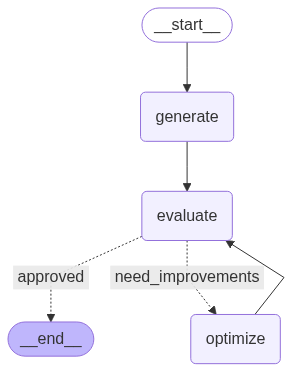

In [36]:
graph.add_node('generate',generate_tweet)
graph.add_node('evaluate',evaluate_tweet)
graph.add_node('optimize',optimize_tweet)

graph.add_edge(START,'generate')
graph.add_edge('generate','evaluate')

graph.add_conditional_edges('evaluate',route_evaluation,{'approved':END,'need_improvements':'optimize'})
graph.add_edge('optimize','evaluate')

workflow=graph.compile()
workflow

In [39]:
initial_state={
    'topic':'Indian Roads',
    'iteration':1,
    'max_iterations':5
}
workflow.invoke(initial_state)

{'topic': 'Indian Roads',
 'tweet': "Indian roads: where GPS says 'recalculating' but the detour is actually a scenic route through pothole park, traffic jam, and a random street vendor selling chai. At least we get a free latte of chaos. #RoadTrip #India",
 'evaluation': 'approved',
 'feedback': 'The tweet is original, humorous, and punchy. It effectively captures the chaos of Indian roads with a unique twist, making it relatable and funny. The format is well-executed, avoiding common pitfalls, and the use of cultural elements adds depth. It has strong virality potential due to its relatability and clever wordplay.',
 'iteration': 1,
 'tweet_history': ["Indian roads: where GPS says 'recalculating' but the detour is actually a scenic route through pothole park, traffic jam, and a random street vendor selling chai. At least we get a free latte of chaos. #RoadTrip #India"],
 'feedback_history': ['The tweet is original, humorous, and punchy. It effectively captures the chaos of Indian roa